<a href="https://colab.research.google.com/github/FMagnani/Physics_Informed_NeuralNetwork/blob/main/Allen-Cahn_Discrete/Raissi_Allen_Cahn_Discrete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The original code of Raissi, written in Tensorflow version 1.  
The code gives a good result with about 5000 Adam iterations + 10000 LBFGS iterations.  
The training -with CPU- takes about 1 hour. Maybe this time can be reduced employing GPU acceleration.

# Requirements

Cloning GitHub repo 

In [ ]:
!git clone https://github.com/maziarraissi/PINNs.git

Cloning into 'PINNs'...
remote: Enumerating objects: 741, done.
remote: Total 741 (delta 0), reused 0 (delta 0), pack-reused 741
Receiving objects: 100% (741/741), 474.47 MiB | 27.04 MiB/s, done.
Resolving deltas: 100% (66/66), done.
Checking out files: 100% (561/561), done.


Move to the directory for the Allen-Cahn discrete time model

In [ ]:
cd PINNs/main/discrete_time_inference (AC)/

/content/PINNs/main/discrete_time_inference (AC)


#Class definition
(In this cell LBFGS iterations are set)

Importing, using TF1

In [ ]:

import sys
sys.path.insert(0, '../../Utilities/')

%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable


TensorFlow 1.x selected.


Class definition - LBFGS SET TO 1000

In [ ]:

class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, x0, u0, x1, layers, dt, lb, ub, q):
        
        self.lb = lb
        self.ub = ub
        
        self.x0 = x0
        self.x1 = x1
        
        self.u0 = u0
        
        self.layers = layers
        self.dt = dt
        self.q = max(q,1)
    
        # Initialize NN
        self.weights, self.biases = self.initialize_NN(layers)
        
        # Load IRK weights
        tmp = np.float32(np.loadtxt('../../Utilities/IRK_weights/Butcher_IRK%d.txt' % (q), ndmin = 2))
        self.IRK_weights = np.reshape(tmp[0:q**2+q], (q+1,q))
        self.IRK_times = tmp[q**2+q:]
        
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        self.x0_tf = tf.placeholder(tf.float32, shape=(None, self.x0.shape[1]))
        self.x1_tf = tf.placeholder(tf.float32, shape=(None, self.x1.shape[1]))
        self.u0_tf = tf.placeholder(tf.float32, shape=(None, self.u0.shape[1]))
        self.dummy_x0_tf = tf.placeholder(tf.float32, shape=(None, self.q)) # dummy variable for fwd_gradients
        self.dummy_x1_tf = tf.placeholder(tf.float32, shape=(None, self.q+1)) # dummy variable for fwd_gradients
        
        self.U0_pred = self.net_U0(self.x0_tf) # N x (q+1)
        self.U1_pred, self.U1_x_pred= self.net_U1(self.x1_tf) # N1 x (q+1)
        
        self.loss = tf.reduce_sum(tf.square(self.u0_tf - self.U0_pred)) + \
                    tf.reduce_sum(tf.square(self.U1_pred[0,:] - self.U1_pred[1,:])) + \
                    tf.reduce_sum(tf.square(self.U1_x_pred[0,:] - self.U1_x_pred[1,:]))                     
        
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 1000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})
        
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
        
        init = tf.global_variables_initializer()
        self.sess.run(init)
        
    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    
    def fwd_gradients_0(self, U, x):        
        g = tf.gradients(U, x, grad_ys=self.dummy_x0_tf)[0]
        return tf.gradients(g, self.dummy_x0_tf)[0]
    
    def fwd_gradients_1(self, U, x):        
        g = tf.gradients(U, x, grad_ys=self.dummy_x1_tf)[0]
        return tf.gradients(g, self.dummy_x1_tf)[0]
    
    def net_U0(self, x):
        U1 = self.neural_net(x, self.weights, self.biases)
        U = U1[:,:-1]
        U_x = self.fwd_gradients_0(U, x)
        U_xx = self.fwd_gradients_0(U_x, x)
        F = 5.0*U - 5.0*U**3 + 0.0001*U_xx
        U0 = U1 - self.dt*tf.matmul(F, self.IRK_weights.T)
        return U0

    def net_U1(self, x):
        U1 = self.neural_net(x, self.weights, self.biases)
        U1_x = self.fwd_gradients_1(U1, x)
        return U1, U1_x # N x (q+1)
    
    def callback(self, loss):
        print('Loss:', loss)
    
    def train(self, nIter):
        tf_dict = {self.x0_tf: self.x0, self.u0_tf: self.u0, self.x1_tf: self.x1,
                   self.dummy_x0_tf: np.ones((self.x0.shape[0], self.q)),
                   self.dummy_x1_tf: np.ones((self.x1.shape[0], self.q+1))}
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                print('It: %d, Loss: %.3e, Time: %.2f' % 
                      (it, loss_value, elapsed))
                start_time = time.time()
    
        self.optimizer.minimize(self.sess,
                                feed_dict = tf_dict,
                                fetches = [self.loss],
                                loss_callback = self.callback)
    
    def predict(self, x_star):
        
        U1_star = self.sess.run(self.U1_pred, {self.x1_tf: x_star})
                    
        return U1_star


#Data preparation and model initialization

In [ ]:

np.random.seed(1234)
tf.set_random_seed(1234)

if __name__ == "__main__": 
        
    q = 100
    layers = [1, 200, 200, 200, 200, q+1]
    lb = np.array([-1.0])
    ub = np.array([1.0])
    
    N = 200
    
    data = scipy.io.loadmat('../Data/AC.mat')
    
    t = data['tt'].flatten()[:,None] # T x 1
    x = data['x'].flatten()[:,None] # N x 1
    Exact = np.real(data['uu']).T # T x N
    
    idx_t0 = 20
    idx_t1 = 180
    dt = t[idx_t1] - t[idx_t0]
    
    # Initial data
    noise_u0 = 0.0
    idx_x = np.random.choice(Exact.shape[1], N, replace=False) 
    x0 = x[idx_x,:]
    u0 = Exact[idx_t0:idx_t0+1,idx_x].T
    u0 = u0 + noise_u0*np.std(u0)*np.random.randn(u0.shape[0], u0.shape[1])
    
       
    # Boudanry data
    x1 = np.vstack((lb,ub))
    
    # Test data
    x_star = x

    model = PhysicsInformedNN(x0, u0, x1, layers, dt, lb, ub, q)
   

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



# Training

In [ ]:
model.train(5000)

Streaming output truncated to the last 5000 lines.
Loss: 0.031877227
Loss: 0.031817738
Loss: 0.031796947
Loss: 0.031785283
Loss: 0.03177494
Loss: 0.031762145
Loss: 0.03174373
Loss: 0.031729557
Loss: 0.031718373
Loss: 0.03170617
Loss: 0.03169227
Loss: 0.03168304
Loss: 0.03167234
Loss: 0.031655613
Loss: 0.031806372
Loss: 0.031648736
Loss: 0.03163272
Loss: 0.031620555
Loss: 0.031607457
Loss: 0.031592652
Loss: 0.031585064
Loss: 0.031573087
Loss: 0.031560235
Loss: 0.03158401
Loss: 0.031552766
Loss: 0.031537835
Loss: 0.031530336
Loss: 0.03151304
Loss: 0.031539593
Loss: 0.031507593
Loss: 0.031499688
Loss: 0.031491317
Loss: 0.03148016
Loss: 0.03150684
Loss: 0.031475447
Loss: 0.031462383
Loss: 0.03144984
Loss: 0.031428274
Loss: 0.03140909
Loss: 0.031416
Loss: 0.031399015
Loss: 0.031389307
Loss: 0.031381585
Loss: 0.031375103
Loss: 0.03136691
Loss: 0.031357788
Loss: 0.031349402
Loss: 0.03133208
Loss: 0.031343788
Loss: 0.031324282
Loss: 0.03131018
Loss: 0.031299725
Loss: 0.031287648
Loss: 0.031306

Prediction

In [ ]:
U1_pred = model.predict(x_star)

error = np.linalg.norm(U1_pred[:,-1] - Exact[idx_t1,:], 2)/np.linalg.norm(Exact[idx_t1,:], 2)
print('Error: %e' % (error))


Error: 6.646323e-03


#Plotting

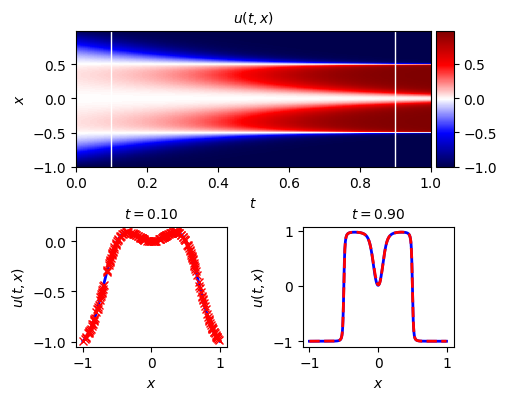

In [ ]:
if __name__ == "__main__": 

    plt.style.use('default')

    ######################################################################
    ############################# Plotting ###############################
    ######################################################################    

    fig, ax = newfig(1.0, 1.2)
    ax.axis('off')
    
    ####### Row 0: h(t,x) ##################    
    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1-0.06, bottom=1-1/2 + 0.1, left=0.15, right=0.85, wspace=0)
    ax = plt.subplot(gs0[:, :])
    
    h = ax.imshow(Exact.T, interpolation='nearest', cmap='seismic', 
                  extent=[t.min(), t.max(), x_star.min(), x_star.max()], 
                  origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
        
    line = np.linspace(x.min(), x.max(), 2)[:,None]
    ax.plot(t[idx_t0]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[idx_t1]*np.ones((2,1)), line, 'w-', linewidth = 1)
    
    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.set_title('$u(t,x)$', fontsize = 10)
    
    
    ####### Row 1: h(t,x) slices ##################    
    gs1 = gridspec.GridSpec(1, 2)
    gs1.update(top=1-1/2-0.05, bottom=0.15, left=0.15, right=0.85, wspace=0.5)
    
    ax = plt.subplot(gs1[0, 0])
    ax.plot(x,Exact[idx_t0,:], 'b-', linewidth = 2) 
    ax.plot(x0, u0, 'rx', linewidth = 2, label = 'Data')      
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')    
    ax.set_title('$t = %.2f$' % (t[idx_t0]), fontsize = 10)
    ax.set_xlim([lb-0.1, ub+0.1])
   
    ax = plt.subplot(gs1[0, 1])
    ax.plot(x,Exact[idx_t1,:], 'b-', linewidth = 2, label = 'Exact') 
    ax.plot(x_star, U1_pred[:,-1], 'r--', linewidth = 2, label = 'Prediction')      
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')    
    ax.set_title('$t = %.2f$' % (t[idx_t1]), fontsize = 10)    
    ax.set_xlim([lb-0.1, ub+0.1])
 

# Predictions from the stages, **dt = 0.4**

In [ ]:
idx_t0 = 20
idx_t1 = 100
dt = t[idx_t1] - t[idx_t0]

q = 100
layers = [1, 200, 200, 200, 200, q+1]

u0 = Exact[idx_t0:idx_t0+1,idx_x].T

model = PhysicsInformedNN(x0, u0, x1, layers, dt, lb, ub, q)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



## Training

3000 Adam + 500 LBFGS

In [ ]:
model.train(3000)

It: 0, Loss: 4.103e+03, Time: 0.64
It: 10, Loss: 3.701e+03, Time: 0.10
It: 20, Loss: 2.848e+03, Time: 0.11
It: 30, Loss: 2.538e+03, Time: 0.11
It: 40, Loss: 2.411e+03, Time: 0.10
It: 50, Loss: 2.382e+03, Time: 0.09
It: 60, Loss: 2.365e+03, Time: 0.10
It: 70, Loss: 2.355e+03, Time: 0.10
It: 80, Loss: 2.349e+03, Time: 0.11
It: 90, Loss: 2.348e+03, Time: 0.10
It: 100, Loss: 2.341e+03, Time: 0.10
It: 110, Loss: 2.337e+03, Time: 0.11
It: 120, Loss: 2.327e+03, Time: 0.11
It: 130, Loss: 2.292e+03, Time: 0.11
It: 140, Loss: 2.089e+03, Time: 0.10
It: 150, Loss: 1.378e+03, Time: 0.11
It: 160, Loss: 7.452e+02, Time: 0.11
It: 170, Loss: 5.417e+02, Time: 0.10
It: 180, Loss: 4.518e+02, Time: 0.10
It: 190, Loss: 4.432e+02, Time: 0.10
It: 200, Loss: 3.927e+02, Time: 0.10
It: 210, Loss: 3.799e+02, Time: 0.10
It: 220, Loss: 3.744e+02, Time: 0.10
It: 230, Loss: 3.656e+02, Time: 0.10
It: 240, Loss: 3.618e+02, Time: 0.10
It: 250, Loss: 3.574e+02, Time: 0.10
It: 260, Loss: 3.534e+02, Time: 0.12
It: 270, Los

Prediction

In [ ]:

U_test_pred = model.predict(x_star)

error = np.linalg.norm(U_test_pred[:,-1] - Exact[idx_t1,:], 2)/np.linalg.norm(Exact[idx_t1,:], 2)
print('Error: %e' % (error))


Error: 7.811755e-03


##Plotting

Define plot_slice

In [ ]:

def plot_slice(ax, u_slice, x_slice, Exact,x,idx_t,t, RKstage):  

    plt.style.use('default')

    ax.tick_params(left = True, right = False , labelleft = True,
                labelbottom = False, bottom = False)

    ax.plot(x,Exact[idx_t,:], 'b-', linewidth = 2, label = 'Exact') 
    ax.plot(x_star, u_slice, 'r--', linewidth = 2, label = 'Prediction')      
#    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')    
    ax.set_title('stage: '+str(RKstage)+', $t = %.2f$' % (t[idx_t]), fontsize = 10)    
    ax.set_xlim([lb-0.1, ub+0.1])
 
    return ax


Plotting

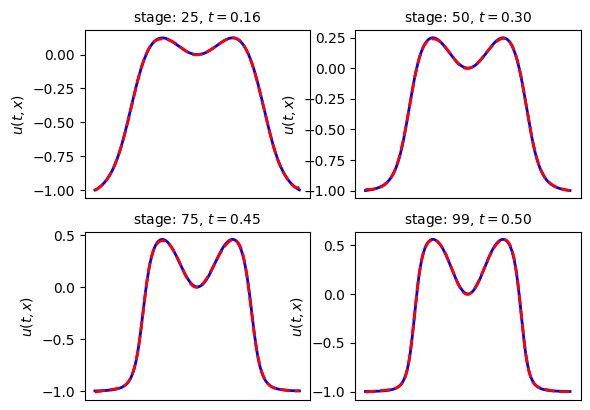

In [ ]:
fig, ax = plt.subplots(2,2)

times = model.IRK_times

idx_1 = 25
idx_2 = 50
idx_3 = 75
idx_4 = 99

idx_t_1 = 32
idx_t_2 = 61
idx_t_3 = 89
idx_t_4 = 100

plot_slice(ax[0,0], U_test_pred[:, idx_1],x_star, Exact,x,idx_t_1,t, idx_1)
plot_slice(ax[0,1], U_test_pred[:, idx_2],x_star, Exact,x,idx_t_2,t, idx_2)
plot_slice(ax[1,0], U_test_pred[:, idx_3],x_star, Exact,x,idx_t_3,t, idx_3)
plot_slice(ax[1,1], U_test_pred[:, idx_4],x_star, Exact,x,idx_t_4,t, idx_4)


In [ ]:
t[20] + times[99]*model.dt, t[100]

(array([0.49994276]), array([0.5]))

Save figure

In [ ]:
fig.savefig('RKstages')

# dt = 0.98

In [ ]:
idx_t0 = 0
idx_t1 = 196
dt = t[idx_t1] - t[idx_t0]

u0 = Exact[idx_t0:idx_t0+1,idx_x].T

model = PhysicsInformedNN(x0, u0, x1, layers, dt, lb, ub, q)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



## Training

5000 Adam + 1000 LBFGS

In [ ]:
model.train(5000)

It: 0, Loss: 2.792e+03, Time: 2.16
It: 10, Loss: 2.426e+03, Time: 0.10
It: 20, Loss: 2.421e+03, Time: 0.10
It: 30, Loss: 2.415e+03, Time: 0.10
It: 40, Loss: 2.411e+03, Time: 0.11
It: 50, Loss: 2.410e+03, Time: 0.10
It: 60, Loss: 2.410e+03, Time: 0.11
It: 70, Loss: 2.409e+03, Time: 0.10
It: 80, Loss: 2.408e+03, Time: 0.10
It: 90, Loss: 2.407e+03, Time: 0.10
It: 100, Loss: 2.405e+03, Time: 0.10
It: 110, Loss: 2.396e+03, Time: 0.09
It: 120, Loss: 1.977e+03, Time: 0.10
It: 130, Loss: 2.193e+03, Time: 0.09
It: 140, Loss: 1.929e+03, Time: 0.11
It: 150, Loss: 1.730e+03, Time: 0.10
It: 160, Loss: 1.442e+03, Time: 0.10
It: 170, Loss: 1.241e+03, Time: 0.10
It: 180, Loss: 1.748e+03, Time: 0.10
It: 190, Loss: 1.379e+03, Time: 0.10
It: 200, Loss: 1.196e+03, Time: 0.09
It: 210, Loss: 1.107e+03, Time: 0.10
It: 220, Loss: 1.072e+03, Time: 0.10
It: 230, Loss: 1.056e+03, Time: 0.12
It: 240, Loss: 1.051e+03, Time: 0.10
It: 250, Loss: 1.050e+03, Time: 0.10
It: 260, Loss: 1.047e+03, Time: 0.10
It: 270, Los

Prediction

In [ ]:

U_098_pred = model.predict(x_star)

error = np.linalg.norm(U_098_pred[:,-1] - Exact[idx_t1,:], 2)/np.linalg.norm(Exact[idx_t1,:], 2)
print('Error: %e' % (error))


Error: 5.338999e-01


##Plotting

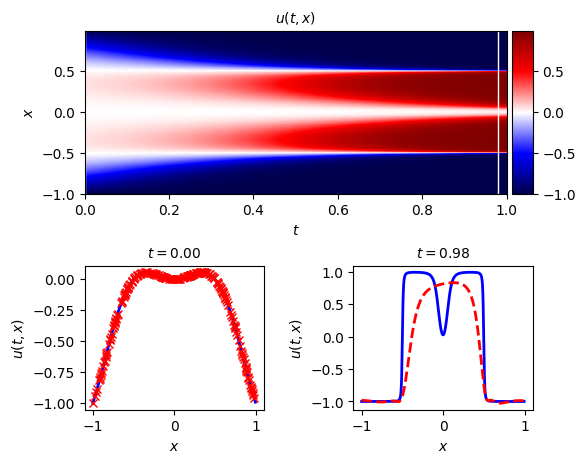

In [ ]:
if __name__ == "__main__": 

    plt.style.use('default')

    ######################################################################
    ############################# Plotting ###############################
    ######################################################################    

    fig, ax = plt.subplots(1, 1)
    ax.axis('off')
    
    ####### Row 0: h(t,x) ##################    
    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1-0.06, bottom=1-1/2 + 0.1, left=0.15, right=0.85, wspace=0)
    ax = plt.subplot(gs0[:, :])
    
    h = ax.imshow(Exact.T, interpolation='nearest', cmap='seismic', 
                  extent=[t.min(), t.max(), x_star.min(), x_star.max()], 
                  origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
        
    line = np.linspace(x.min(), x.max(), 2)[:,None]
    ax.plot(t[idx_t0]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[idx_t1]*np.ones((2,1)), line, 'w-', linewidth = 1)
    
    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.set_title('$u(t,x)$', fontsize = 10)
    
    
    ####### Row 1: h(t,x) slices ##################    
    gs1 = gridspec.GridSpec(1, 2)
    gs1.update(top=1-1/2-0.05, bottom=0.15, left=0.15, right=0.85, wspace=0.5)
    
    ax = plt.subplot(gs1[0, 0])
    ax.plot(x,Exact[idx_t0,:], 'b-', linewidth = 2) 
    ax.plot(x0, u0, 'rx', linewidth = 2, label = 'Data')      
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')    
    ax.set_title('$t = %.2f$' % (t[idx_t0]), fontsize = 10)
    ax.set_xlim([lb-0.1, ub+0.1])
   
    ax = plt.subplot(gs1[0, 1])
    ax.plot(x,Exact[idx_t1,:], 'b-', linewidth = 2, label = 'Exact') 
    ax.plot(x_star, U_098_pred[:,-1], 'r--', linewidth = 2, label = 'Prediction')      
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')    
    ax.set_title('$t = %.2f$' % (t[idx_t1]), fontsize = 10)    
    ax.set_xlim([lb-0.1, ub+0.1])
 

In [ ]:
fig.savefig('AC_098')

## Predictions from the stages of dt = 0.98

Define plot_slice

In [ ]:

def plot_slice(ax, u_slice, x_slice, Exact,x,idx_t,t, RKstage):  

    plt.style.use('default')

    ax.tick_params(left = True, right = False , labelleft = True,
                labelbottom = False, bottom = False)

    ax.plot(x,Exact[idx_t,:], 'b-', linewidth = 2, label = 'Exact') 
    ax.plot(x_star, u_slice, 'r--', linewidth = 2, label = 'Prediction')      
#    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')    
    ax.set_title('stage: '+str(RKstage)+', $t = %.2f$' % (t[idx_t]), fontsize = 10)    
    ax.set_xlim([lb-0.1, ub+0.1])
 
    return ax


Plotting

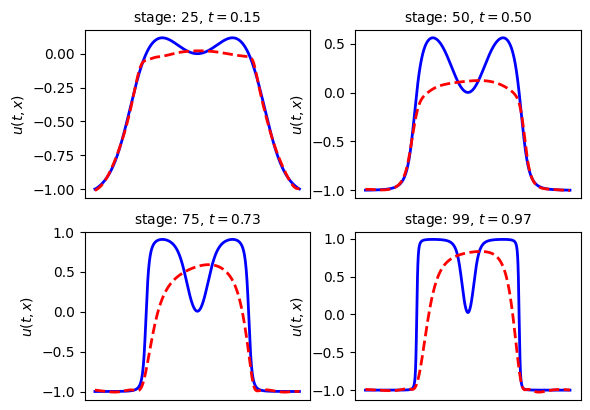

In [ ]:
fig, ax = plt.subplots(2,2)

times = model.IRK_times

idx_1 = 25 # 0.15
idx_2 = 50 # 0.50
idx_3 = 75 # 0.73
idx_4 = 99 # 0.97

idx_t_1 = 30  # 0.15
idx_t_2 = 100 # 0.50
idx_t_3 = 146 # 0.73
idx_t_4 = 194 # 0.97

plot_slice(ax[0,0], U_098_pred[:, idx_1],x_star, Exact,x,idx_t_1,t, idx_1)
plot_slice(ax[0,1], U_098_pred[:, idx_2],x_star, Exact,x,idx_t_2,t, idx_2)
plot_slice(ax[1,0], U_098_pred[:, idx_3],x_star, Exact,x,idx_t_3,t, idx_3)
plot_slice(ax[1,1], U_098_pred[:, idx_4],x_star, Exact,x,idx_t_4,t, idx_4)


Save figure

In [ ]:
fig.savefig('RKstages_098')